# Visualizing Loci
Uses GeneticsMakie.jl to produce LocusZoom style plots

## Loading in packages and data
Loads in Gencode v38 annotations and PGC3 SCZ summary statistics

In [2]:
using CairoMakie,CSV,DataFrames,Glob,SnpArrays
import GeneticsMakie as GM

gencodefilename = "/u/project/gandalm/shared/refGenomes/hg38/v38/gencode.v38.annotation.gtf"
sumstatsfilename = "/u/project/gandalm/shared/GWAS/SCZ.PGC3.2021/PGC3_SCZ_wave3_public.v2.sumstats_coord.gz"
ldfolder = "/u/project/gandalm/shared/apps/ldsc/LDSCORE/1000G_EUR_Phase3_plink"

function loaddata(gencodefilename::AbstractString, sumstatsfilename::AbstractString)
    gencode = CSV.read(gencodefilename, DataFrame; delim = '\t', comment = "#", 
                                        header = ["seqnames", "source", "feature", 
                                                  "start", "end", "score", "strand", 
                                                  "phase", "info"])
    GM.parsegtf!(gencode)
    sumstats = CSV.read(sumstatsfilename, DataFrame)
    GM.mungesumstats!(sumstats)
    return (gencode, sumstats)
end

gencode, sumstats = loaddata(gencodefilename, sumstatsfilename)

(3150424×14 DataFrame
     Row │ seqnames  source   feature      start  end    score    strand   pha ⋯
         │ String    String7  String15     Int64  Int64  String1  String1  Str ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ 1         HAVANA   gene         11869  14409  .        +        .   ⋯
       2 │ 1         HAVANA   transcript   11869  14409  .        +        .
       3 │ 1         HAVANA   exon         11869  12227  .        +        .
       4 │ 1         HAVANA   exon         12613  12721  .        +        .
       5 │ 1         HAVANA   exon         13221  14409  .        +        .   ⋯
       6 │ 1         HAVANA   transcript   12010  13670  .        +        .
       7 │ 1         HAVANA   exon         12010  12057  .        +        .
       8 │ 1         HAVANA   exon         12179  12227  .        +        .
       9 │ 1         HAVANA   exon         12613  12697  .        +        .   ⋯
      10 │ 1         HAVANA   

## Function definitions
pgc3locuszoom
* saves LocusZoom style plot with PGC3 summary statistics
* @param chr::AbstractString - chromosome of the locus
* @param range1::Integer - base pair position of start of locus
* @param range1::Integer - base pair position of end of locus
* @param outpath::AbstractString - output path
* @param outname::AbstractString - filename for output, without extension
* @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
* @return - Makie figure visualizing the LocusZoom plot
* side effect - Saves image to outpath/outname.png

coloclocuszoom
* saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
* @param gene::AbstractString - gene to visualize
* @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
* @param colocthresholds::Array{<:Real} - array of signficance thresholds
* @param ldfilename::AbstractString - filename for the LD reference file
* @param outpath::AbstractString - output path
* @param outname::AbstractString - filename for output, without extension
* @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
* @return - Makie figure visualizing the LocusZoom plot
* side effect - Saves image to outpath/outname.png

In [7]:
# pgc3locuszoom
# saves LocusZoom style plot with PGC3 summary statistics
# @param chr::AbstractString - chromosome of the locus
# @param range1::Integer - base pair position of start of locus
# @param range1::Integer - base pair position of end of locus
# @param outpath::AbstractString - output path
# @param outname::AbstractString - filename for output, without extension
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
# side effect - Saves image to <outpath>/<outname>.png
function pgc3locuszoom(chr::AbstractString, range1::Integer, range2::Integer, outpath::AbstractString, outname::AbstractString; snp::Union{AbstractString, Nothing} = nothing)
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall( (ld.snp_info.chromosome .== chr) .&&
                        (ld.snp_info.position .>= range1) .&&
                        (ld.snp_info.position .<= range2) )
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    f = Figure(resolution = (500, 500))
    axs = [Axis(f[i,1]) for i in 1:2]
    if isnothing(snp)
        GM.plotlocus!(axs[1], chr, range1, range2, sumstats, ld = ld)
    else
        GM.plotlocus!(axs[1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[1], [range1, range2], fill(-log(10, 5e-8), 2), color = (:purple, 0.5), linewidth = 0.5)
    Label(f[1, 1, Top()], "PGC3 SCZ", textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, 1, 150)
    rs = GM.plotgenes!(axs[2], chr, range1, range2, gencode)
    rowsize!(f.layout, 2, rs)
    Colorbar(f[1:2, 2], limits = (0, 1), ticks = 0:1:1, height = 20,
        colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
        tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
        labelsize = 6, width = 5, spinewidth = 0.5)
    GM.labelgenome(f[2, 1, Bottom()], chr, range1, range2)
    Label(f[1, 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    colgap!(f.layout, 5)
    resize_to_layout!(f)
    save(joinpath(outpath, outname * ".png"), f, px_per_unit = 4)
    return f
end

# coloclocuszoom
# saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
# @param gene::AbstractString - gene to visualize
# @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
# @param colocthresholds::Array{<:Real} - array of signficance thresholds
# @param ldfilename::AbstractString - filename for the LD reference file
# @param outpath::AbstractString - output path
# @param outname::AbstractString - filename for output, without extension
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
# side effect - Saves image to <outpath>/<outname>.png
function coloc(gene::AbstractString, colocfilenames::Array{<:AbstractString}, colocthresholds::Array{<:Real}, 
               ldfilename::AbstractString, outpath::AbstractString, outname::AbstractString;
               snp::Union{AbstractString, Nothing} = nothing)
    colocfiles = [CSV.read(file, DataFrame; header = 1) for file in colocfilenames]
    ld = SnpData(ldfilename)
    colocfiles = [innerjoin(df, ld.snp_info, on = :MarkerName => :snpid)
                   for df in colocfiles]
    GM.mungesumstats!(colocfiles)
    chr, start, stop = GM.findgene(gene, gencode)
    range1 = start - 1e6
    range2 = stop + 1e6
    colinds = findall( (ld.snp_info.chromosome .== chr) .&&
                        (ld.snp_info.position .>= range1) .&&
                        (ld.snp_info.position .<= range2) )
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    f = Figure(resolution = (500, 1000))
    n = length(colocfiles)
    axs = [Axis(f[i,1]) for i in 1:(n+2)]
    # Visualize eQTLs
    for i in 1:n
        title = match(r"[^_]*", basename(colocfilenames[i])).match
        if isnothing(snp)
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = ld)
        else
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = (ld, snp))
        end
        lines!(axs[i], [range1, range2], fill(colocthresholds[i], 2), color = (:purple, 0.5), linewidth = 0.5)
        vlines!(axs[i], start, color = (:gold, 0.5), linewidth = 0.5)
        vlines!(axs[i], stop, color = (:gold, 0.5), linewidth = 0.5)
        Label(f[i, 1, Top()], title, textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
        rowsize!(f.layout, i, 50)
    end
    # Visualize PGC3
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall( (ld.snp_info.chromosome .== chr) .&&
                        (ld.snp_info.position .>= range1) .&&
                        (ld.snp_info.position .<= range2) )
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    if isnothing(snp)
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = ld)
    else
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[n + 1], [range1, range2], fill(7.3, 2), color = (:purple, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], stop, color = (:gold, 0.5), linewidth = 0.5)
    Label(f[n + 1, 1, Top()], "PGC3 SCZ", textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, n + 1, 50)
    # Visualize genes
    rs = GM.plotgenes!(axs[n + 2], chr, range1, range2, gencode)
    vlines!(axs[n + 2], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 2], stop, color = (:gold, 0.5), linewidth = 0.5)
    rowsize!(f.layout, n + 2, rs)
    Colorbar(f[1:(n+1), 2], limits = (0, 1), ticks = 0:1:1, height = 20,
        colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
        tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
        labelsize = 6, width = 5, spinewidth = 0.5)
    GM.labelgenome(f[n + 2, 1, Bottom()], chr, range1, range2)
    Label(f[1:(n + 1), 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    rowgap!(f.layout, 5)
    resize_to_layout!(f)
    save(joinpath(outpath, outname * ".png"), f, px_per_unit = 4)
    return f
end

coloc (generic function with 2 methods)

## Generating the LocusZoom plots

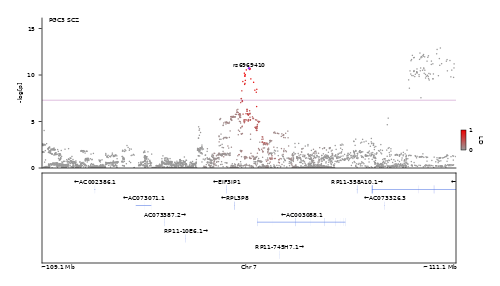

In [6]:
# Visualizing chr7 109069015-111069015
pgc3locuszoom("7", 109069015, 111069015, joinpath(homedir(), "temp"), "chr7locuszoom"; snp = "rs6969410")

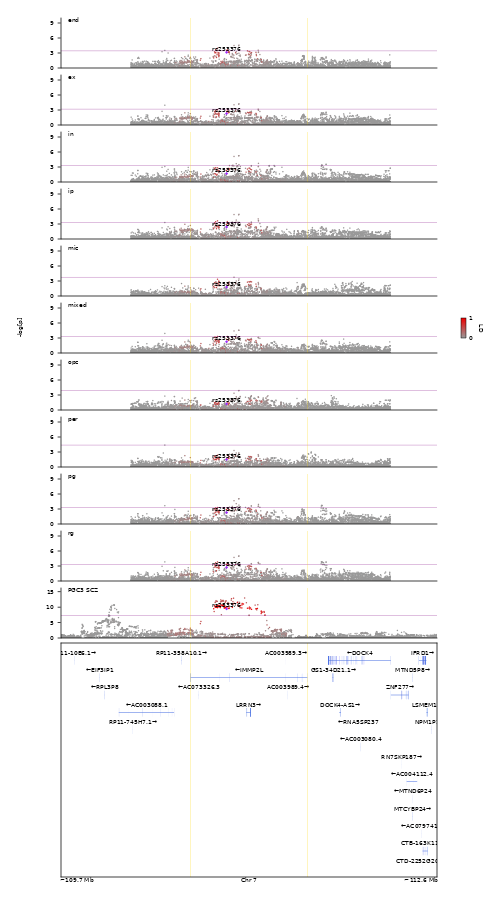

In [8]:
# Visualizing IIMP2L
coloc("IMMP2L",
      readdir(glob"*header*", "/u/project/gandalm/cindywen/isoform_twas/colocal/IMMP2L/"),
      [3.42256, 3.177855, 3.347713, 3.344978, 3.754349, 3.306554, 3.857451, 4.385861, 3.338729, 3.297397],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      joinpath(homedir(), "temp"),
      "IMMP2L_locuszoom";
      snp = "rs253376")